In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

# Load the dataset
df = pd.read_csv("data_files/pre_pandemic.csv")


if df.empty:
    raise ValueError("The dataframe is empty after loading the CSV file.")


df['TIME'] = pd.to_datetime(df['TIME'], format='%Y-%m-%d %H:%M:%S', errors='coerce')


df.dropna(subset=['TIME'], inplace=True)


if df.empty:
    raise ValueError("The dataframe is empty after dropping rows with invalid date conversions.")


start_date = pd.to_datetime('2018-08-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d')


df = df[(df['TIME'] >= start_date) & (df['TIME'] <= end_date)]


df['timestamp'] = df['TIME'].astype(np.int64) // 10**9
diffs = df['timestamp'].diff()


if diffs.size < 2:
    raise ValueError("Not enough data to calculate the sampling interval. Need at least two time points.")

dt = diffs.iloc[1]


df['BIKE USAGE'] = df.groupby('STATION ID')['AVAILABLE BIKES'].diff().fillna(0)


# y = df['AVAILABLE BIKES'].astype(np.float64).values

# Use bike udage instead of available bikes
y = df['BIKE USAGE'].astype(np.float64).values

t = df['timestamp'].values
t = (t - t[0]) / (60 * 60 * 24)

y

array([ 0., -1.,  0., ...,  0.,  0.,  0.])

In [ ]:

def create_features(y, q, dd, lag):
    max_lag = max(q, dd * lag)
    start_idx = max_lag
    end_idx = y.size - q

    XX = y[start_idx - dd * (lag - 1): end_idx - dd * (lag - 1)]
    for i in range(lag - 2, -1, -1):
        X = y[start_idx - dd * i: end_idx - dd * i]
        XX = np.column_stack((XX, X))

    yy = y[start_idx + q: end_idx + q]
    tt = t[start_idx + q: end_idx + q]

    return XX, yy, tt


q = 10
lag = 3
d = math.floor(24 * 60 * 60 / dt)
w = math.floor(7 * 24 * 60 * 60 / dt)


XX, yy, tt = create_features(y, q, 1, lag)
XX_daily, yy_daily, tt_daily = create_features(y, d, d, lag)
XX_weekly, yy_weekly, tt_weekly = create_features(y, w, w, lag)


min_length = min(len(XX), len(XX_daily), len(XX_weekly))


XX = XX[:min_length]
XX_daily = XX_daily[:min_length]
XX_weekly = XX_weekly[:min_length]
yy = yy[:min_length]
tt = tt[:min_length]


XX_combined = np.hstack((XX, XX_daily, XX_weekly))


train, test = train_test_split(np.arange(0, yy.size), test_size=0.2)


model = Ridge(fit_intercept=False)
model.fit(XX_combined[train], yy[train])


y_pred = model.predict(XX_combined)
print(model.coef_)


[0.01459147 0.01428748 0.01811851 0.00675002 0.00189985 0.00289954
 0.0026321  0.00230839 0.00039619]


## NOW PLOT

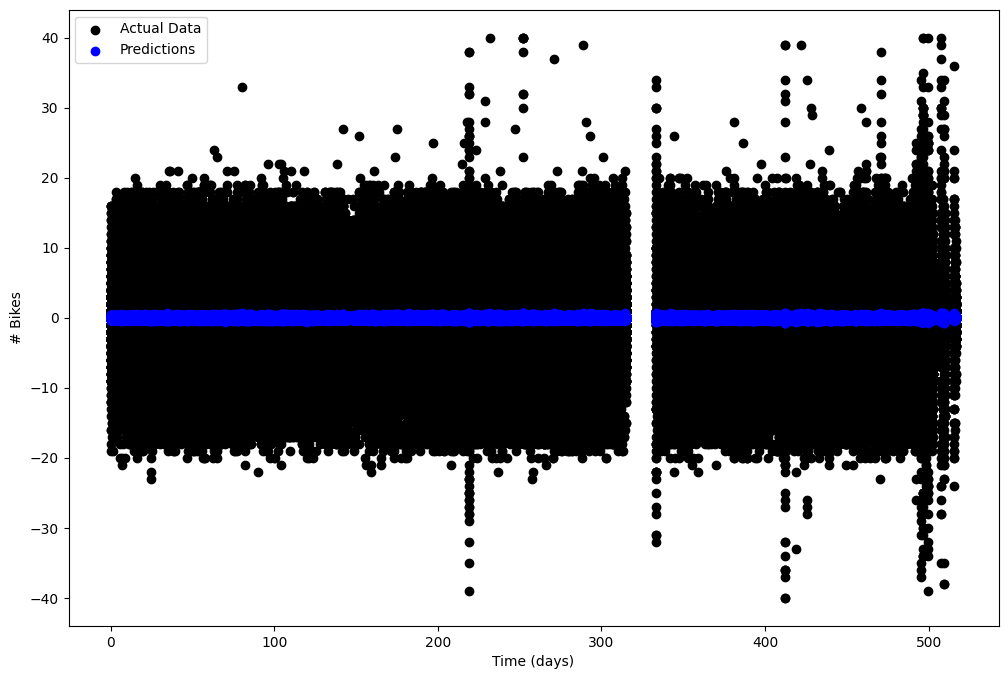

In [ ]:
# Plott the results
plt.figure(figsize=(12, 8))
plt.scatter(tt, yy, color='black')
plt.scatter(tt, y_pred, color='blue')
plt.xlabel("Time (days)")
plt.ylabel("# Bikes")
plt.legend(["Actual Data", "Predictions"])
plt.show()

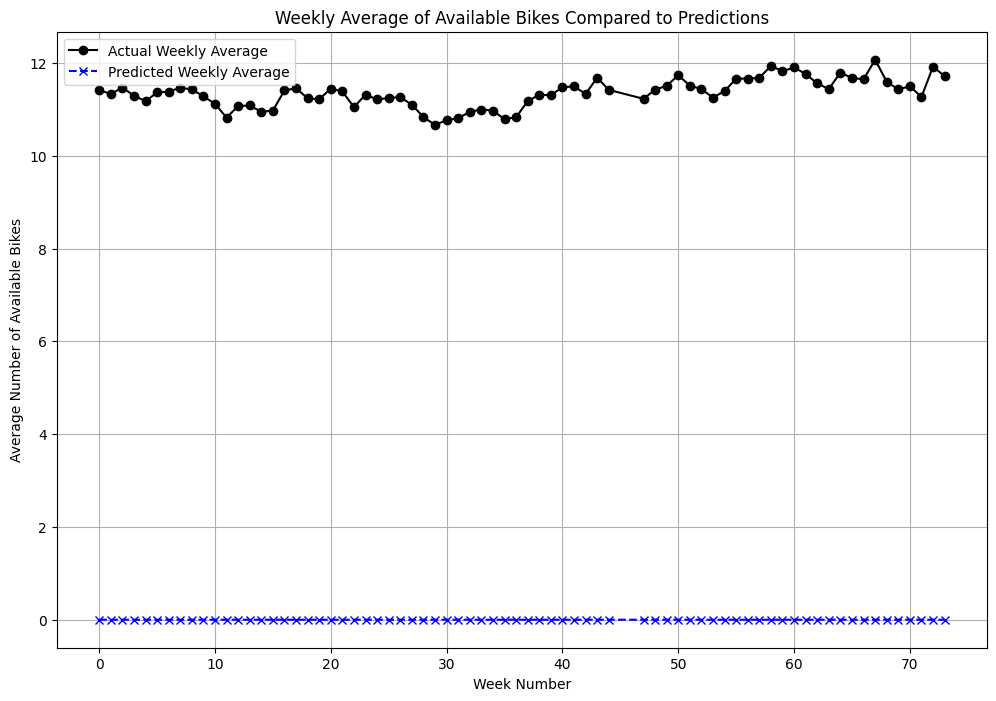

In [ ]:

df['week_number'] = (df['TIME'] - df['TIME'].min()).dt.days // 7


weekly_actual = df.groupby('week_number')['AVAILABLE BIKES'].mean()
weekly_predicted = pd.DataFrame({'TIME': tt, 'y_pred': y_pred}).groupby((tt // 7).astype(int))['y_pred'].mean()

# Plot
plt.figure(figsize=(12, 8))
plt.plot(weekly_actual.index, weekly_actual, marker='o', color='black', label='Actual Weekly Average')
plt.plot(weekly_predicted.index, weekly_predicted, marker='x', color='blue', linestyle='--', label='Predicted Weekly Average')
plt.xlabel("Week Number")
plt.ylabel("Average Number of Available Bikes")
plt.title("Weekly Average of Available Bikes Compared to Predictions")
plt.legend()
plt.grid(True)
plt.show()

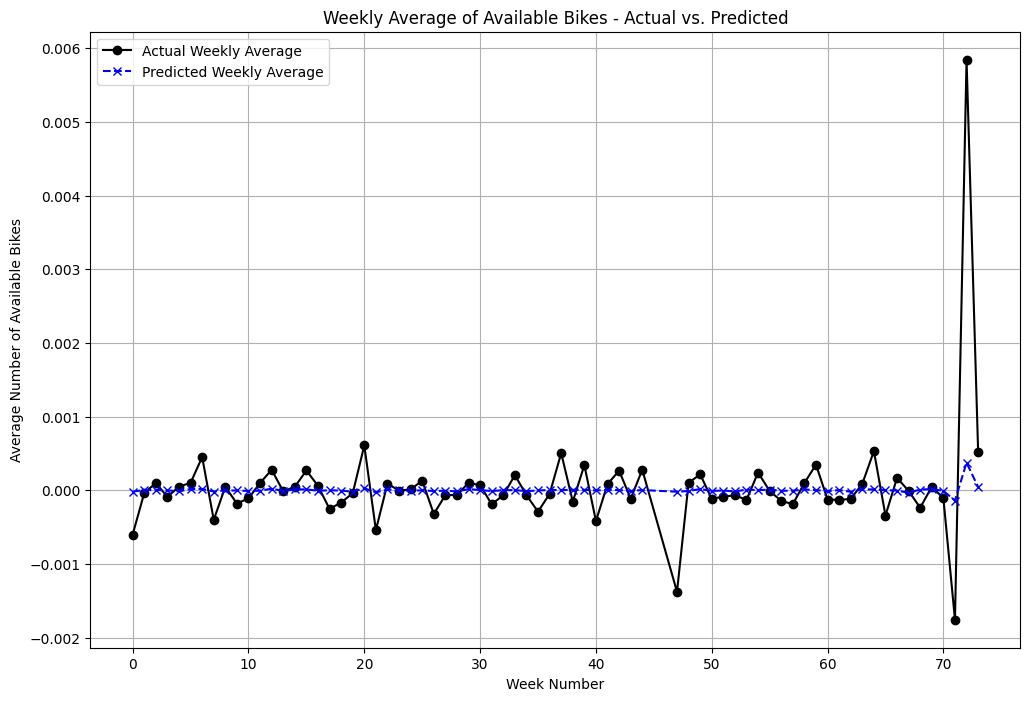

In [ ]:

week_number = np.floor(tt / 7).astype(int)


df_weekly_actual = pd.DataFrame({'Week': week_number, 'ActualBikes': yy})
df_weekly_predicted = pd.DataFrame({'Week': week_number, 'PredictedBikes': y_pred})


weekly_avg_actual = df_weekly_actual.groupby('Week')['ActualBikes'].mean()
weekly_avg_predicted = df_weekly_predicted.groupby('Week')['PredictedBikes'].mean()

# Plot
plt.figure(figsize=(12, 8))
plt.plot(weekly_avg_actual.index, weekly_avg_actual, marker='o', color='black', label='Actual Weekly Average')
plt.plot(weekly_avg_predicted.index, weekly_avg_predicted, marker='x', color='blue', linestyle='--', label='Predicted Weekly Average')
plt.xlabel("Week Number")
plt.ylabel("Average Number of Available Bikes")
plt.title("Weekly Average of Available Bikes - Actual vs. Predicted")
plt.legend()
plt.grid(True)
plt.show()


## NOW PLOT THE BIKE USAGE

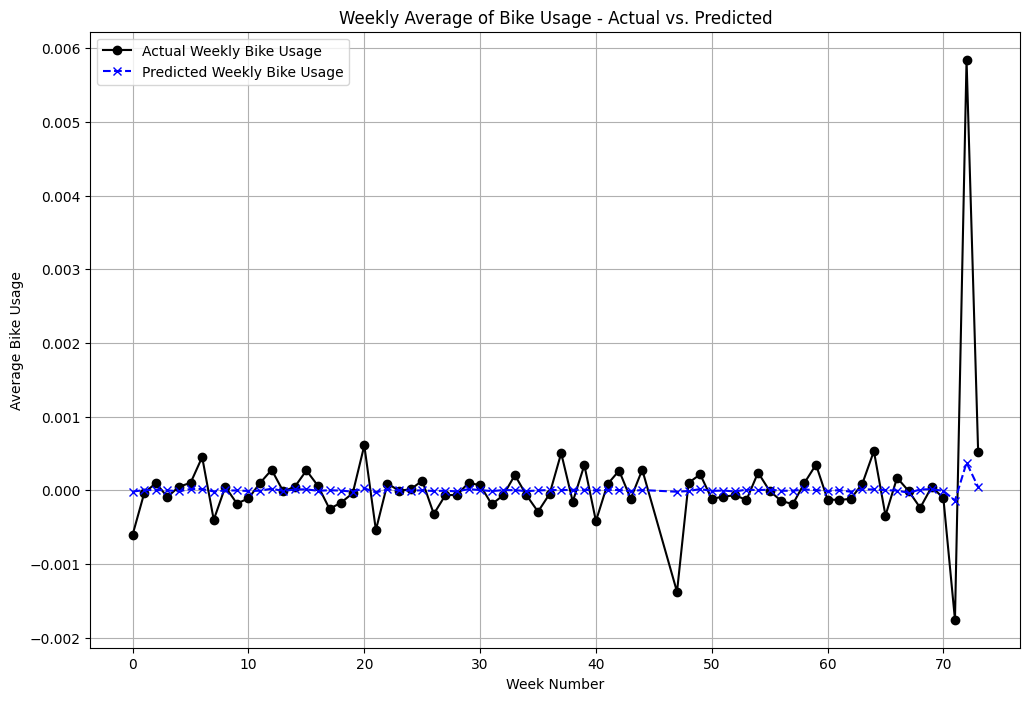

In [ ]:

week_number = np.floor(tt / 7).astype(int)


df_weekly_actual = pd.DataFrame({'Week': week_number, 'ActualBikeUsage': yy})
df_weekly_predicted = pd.DataFrame({'Week': week_number, 'PredictedBikeUsage': y_pred})


weekly_avg_actual = df_weekly_actual.groupby('Week')['ActualBikeUsage'].mean()
weekly_avg_predicted = df_weekly_predicted.groupby('Week')['PredictedBikeUsage'].mean()

# Plot
plt.figure(figsize=(12, 8))
plt.plot(weekly_avg_actual.index, weekly_avg_actual, marker='o', color='black', label='Actual Weekly Bike Usage')
plt.plot(weekly_avg_predicted.index, weekly_avg_predicted, marker='x', color='blue', linestyle='--', label='Predicted Weekly Bike Usage')
plt.xlabel("Week Number")
plt.ylabel("Average Bike Usage")
plt.title("Weekly Average of Bike Usage - Actual vs. Predicted")
plt.legend()
plt.grid(True)
plt.show()

# NOW MAKE PREDICTIONS ON PANDEMIC DATASET

In [ ]:

df_pandemic = pd.read_csv("data_files/pandemic.csv")


df_pandemic['TIME'] = pd.to_datetime(df_pandemic['TIME'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_pandemic.dropna(subset=['TIME'], inplace=True)
df_pandemic['timestamp'] = df_pandemic['TIME'].astype(np.int64) // 10**9
df_pandemic['BIKE USAGE'] = df_pandemic.groupby('STATION ID')['AVAILABLE BIKES'].diff().fillna(0)


y_pandemic = df_pandemic['BIKE USAGE'].astype(np.float64).values
t_pandemic = df_pandemic['timestamp'].values
t_pandemic = (t_pandemic - t_pandemic[0]) / (60 * 60 * 24)  # Convert to days


## Start Craeting features for the pandemic dataset

## CREATING FEATURES ERROR CRRECTION - TEMPORARY

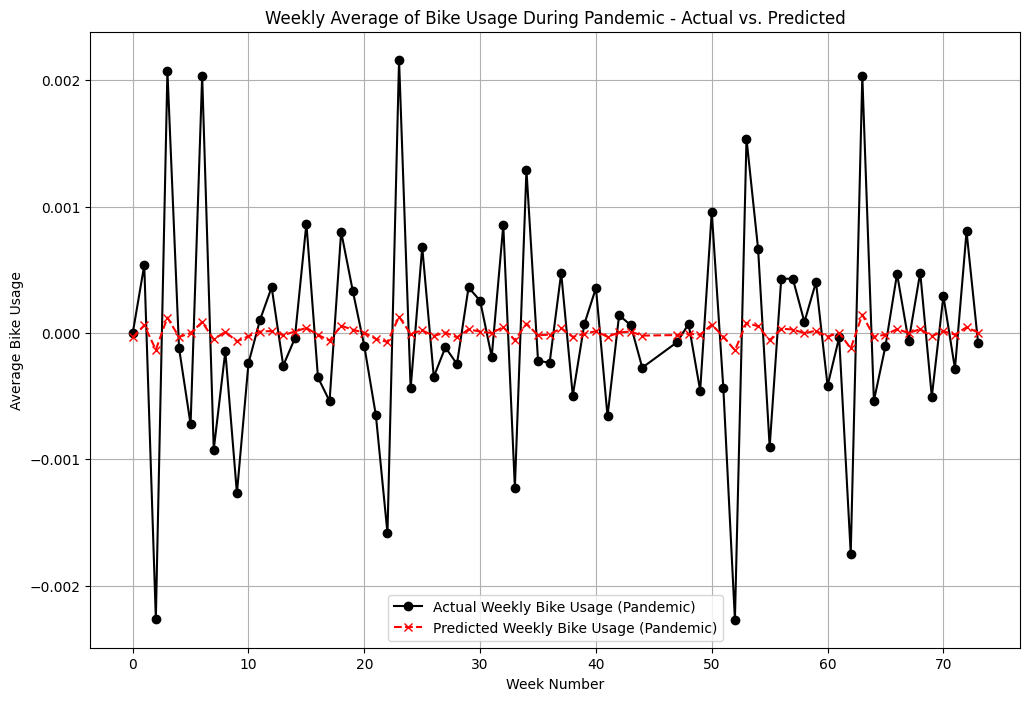

In [ ]:

XX_pandemic, yy_pandemic, tt_pandemic = create_features(y_pandemic, q, 1, lag)
XX_daily_pandemic, _, _ = create_features(y_pandemic, d, d, lag)
XX_weekly_pandemic, _, _ = create_features(y_pandemic, w, w, lag)


min_length_pandemic = min(len(XX_pandemic), len(XX_daily_pandemic), len(XX_weekly_pandemic), len(yy_pandemic), len(tt_pandemic))
XX_pandemic = XX_pandemic[:min_length_pandemic]
XX_daily_pandemic = XX_daily_pandemic[:min_length_pandemic]
XX_weekly_pandemic = XX_weekly_pandemic[:min_length_pandemic]
yy_pandemic = yy_pandemic[:min_length_pandemic]
tt_pandemic = tt_pandemic[:min_length_pandemic]


XX_combined_pandemic = np.hstack((XX_pandemic, XX_daily_pandemic, XX_weekly_pandemic))


y_pred_pandemic = model.predict(XX_combined_pandemic)


week_number_pandemic = np.floor(tt_pandemic / 7).astype(int)


df_weekly_actual_pandemic = pd.DataFrame({'Week': week_number_pandemic[:min_length_pandemic], 'ActualBikeUsage': yy_pandemic})
df_weekly_predicted_pandemic = pd.DataFrame({'Week': week_number_pandemic[:min_length_pandemic], 'PredictedBikeUsage': y_pred_pandemic})


weekly_avg_actual_pandemic = df_weekly_actual_pandemic.groupby('Week')['ActualBikeUsage'].mean()
weekly_avg_predicted_pandemic = df_weekly_predicted_pandemic.groupby('Week')['PredictedBikeUsage'].mean()

# Plot
plt.figure(figsize=(12, 8))
plt.plot(weekly_avg_actual_pandemic.index, weekly_avg_actual_pandemic, marker='o', color='black', label='Actual Weekly Bike Usage (Pandemic)')
plt.plot(weekly_avg_predicted_pandemic.index, weekly_avg_predicted_pandemic, marker='x', color='red', linestyle='--', label='Predicted Weekly Bike Usage (Pandemic)')
plt.xlabel("Week Number")
plt.ylabel("Average Bike Usage")
plt.title("Weekly Average of Bike Usage During Pandemic - Actual vs. Predicted")
plt.legend()
plt.grid(True)
plt.show()


## EVALUATE METRIC

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


y_train_pred = model.predict(XX_combined[train])


mae_train = mean_absolute_error(yy[train], y_train_pred)
mse_train = mean_squared_error(yy[train], y_train_pred)
r2_train = r2_score(yy[train], y_train_pred)

print(f"Training Data - MAE: {mae_train}, MSE: {mse_train}, R²: {r2_train}")


y_pandemic_pred = model.predict(XX_combined_pandemic)




mae_pandemic = mean_absolute_error(yy_pandemic, y_pandemic_pred)
mse_pandemic = mean_squared_error(yy_pandemic, y_pandemic_pred)
r2_pandemic = r2_score(yy_pandemic, y_pandemic_pred)

print(f"Pandemic Data - MAE: {mae_pandemic}, MSE: {mse_pandemic}, R²: {r2_pandemic}")


Training Data - MAE: 0.4122104278665923, MSE: 1.0963507009202238, R²: 0.001017049081703525
Pandemic Data - MAE: 0.20687761115824954, MSE: 0.4407291889565259, R²: -0.00048083439087576174


## Now evaluate for post pandemic

In [ ]:
# Load dataset
df_post_pandemic = pd.read_csv("data_files/post_pandemic.csv")


df_post_pandemic.rename(columns={'AVAILABLE_BIKE_STANDS':'AVAILABLE BIKE STANDS',
                        'AVAILABLE_BIKES': 'AVAILABLE BIKES'}, inplace=True)


df_post_pandemic['TIME'] = pd.to_datetime(df_post_pandemic['TIME'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_post_pandemic.dropna(subset=['TIME'], inplace=True)
df_post_pandemic['timestamp'] = df_post_pandemic['TIME'].astype(np.int64) // 10**9
df_post_pandemic['BIKE USAGE'] = df_post_pandemic.groupby('STATION ID')['AVAILABLE BIKES'].diff().fillna(0)


y_post_pandemic = df_post_pandemic['BIKE USAGE'].astype(np.float64).values
t_post_pandemic = df_post_pandemic['timestamp'].values
t_post_pandemic = (t_post_pandemic - t_post_pandemic[0]) / (60 * 60 * 24)  # Convert to days


In [ ]:

XX_post_pandemic, _, _ = create_features(y_post_pandemic, q, 1, lag)
XX_daily_post_pandemic, _, _ = create_features(y_post_pandemic, d, d, lag)
XX_weekly_post_pandemic, _, _ = create_features(y_post_pandemic, w, w, lag)


min_length_post_pandemic = min(len(XX_post_pandemic), len(XX_daily_post_pandemic), len(XX_weekly_post_pandemic))
XX_post_pandemic = XX_post_pandemic[:min_length_post_pandemic]
XX_daily_post_pandemic = XX_daily_post_pandemic[:min_length_post_pandemic]
XX_weekly_post_pandemic = XX_weekly_post_pandemic[:min_length_post_pandemic]


XX_combined_post_pandemic = np.hstack((XX_post_pandemic, XX_daily_post_pandemic, XX_weekly_post_pandemic))


In [ ]:

y_pred_post_pandemic = model.predict(XX_combined_post_pandemic)


In [ ]:

yy_post_pandemic_actual = df_post_pandemic['BIKE USAGE'].values


In [ ]:

trim_length = len(yy_post_pandemic_actual) - len(y_pred_post_pandemic)
yy_post_pandemic_actual_aligned = yy_post_pandemic_actual[trim_length:]


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_post_pandemic = mean_absolute_error(yy_post_pandemic_actual_aligned, y_pred_post_pandemic)
mse_post_pandemic = mean_squared_error(yy_post_pandemic_actual_aligned, y_pred_post_pandemic)
r2_post_pandemic = r2_score(yy_post_pandemic_actual_aligned, y_pred_post_pandemic)

print(f"Post-Pandemic Data - MAE: {mae_post_pandemic}, MSE: {mse_post_pandemic}, R²: {r2_post_pandemic}")



Post-Pandemic Data - MAE: 1.1028390855476318, MSE: 4.995889078681334, R²: -0.000956519890063845


# PLOT POST PANDEMIC

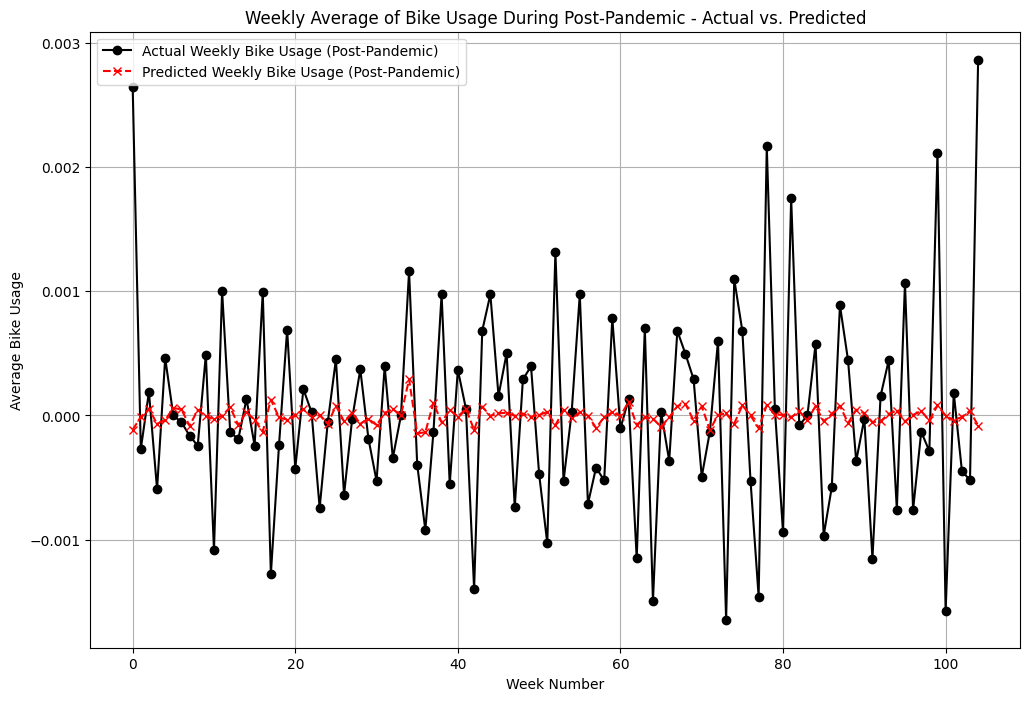

In [ ]:

week_number_post_pandemic = np.floor(t_post_pandemic / 7).astype(int)


week_number_post_pandemic_aligned = week_number_post_pandemic[trim_length:]


df_weekly_actual_post_pandemic = pd.DataFrame({'Week': week_number_post_pandemic_aligned, 'ActualBikeUsage': yy_post_pandemic_actual_aligned})
df_weekly_predicted_post_pandemic = pd.DataFrame({'Week': week_number_post_pandemic_aligned, 'PredictedBikeUsage': y_pred_post_pandemic})


weekly_avg_actual_post_pandemic = df_weekly_actual_post_pandemic.groupby('Week')['ActualBikeUsage'].mean()
weekly_avg_predicted_post_pandemic = df_weekly_predicted_post_pandemic.groupby('Week')['PredictedBikeUsage'].mean()

plt.figure(figsize=(12, 8))
plt.plot(weekly_avg_actual_post_pandemic.index, weekly_avg_actual_post_pandemic, marker='o', color='black', label='Actual Weekly Bike Usage (Post-Pandemic)')
plt.plot(weekly_avg_predicted_post_pandemic.index, weekly_avg_predicted_post_pandemic, marker='x', color='red', linestyle='--', label='Predicted Weekly Bike Usage (Post-Pandemic)')
plt.xlabel("Week Number")
plt.ylabel("Average Bike Usage")
plt.title("Weekly Average of Bike Usage During Post-Pandemic - Actual vs. Predicted")
plt.legend()
plt.grid(True)
plt.show()
